# Assignment 3, Part A
Multi-Layer Perceptron (MLP) neural network models developed to classify handwritten digits (0-9)
from the MNIST (Modified National Institute of Standards and Technology) Dataset. Models created
based on unique specifications for eachexperiment. The MLP model will be trained using the
Backpropagation algorithm that implemented using the mini-batch Stochastic Gradient Descent (SGD)
optimization algorithm.

Mini-batch size set to 64. Network trained to 50 epochs with early stopping enabled.

### MNIST (Modified National Institute of Standards and Technology) Dataset
Set of 70,000 small images of digits handwritten by high school students and employees of the US
Census Bureau. Each image is labeled with the digit it represents. The train set contains 60,000 
images, from which you should randomly select 5000 images as the validation set. 

##### Source:
- Data loaded directly using the Keras API: https://keras.io/api/datasets/mnist/ 

##### Input variables:
- 28x28=784 greyscale pixels
    - Pixel intensity: 0 (white) to 255 (black)

##### Output variable: 
- 10 classes representing integer values from 0 to 9


In [52]:
import tensorflow as tf


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Load Data & Display Dataset Information

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
x_train Min: 0
x_train Max: 255
y_train Min: 0
y_train Max: 9
x_train dtype: uint8
y_train dtype: uint8
Training ( 0 ) -  5923 ; Test ( 0 ) -  980
Training ( 1 ) -  6742 ; Test ( 1 ) -  1135
Training ( 2 ) -  5958 ; Test ( 2 ) -  1032
Training ( 3 ) -  6131 ; Test ( 3 ) -  1010
Training ( 4 ) -  5842 ; Test ( 4 ) -  982
Training ( 5 ) -  5421 ; Test ( 5 ) -  892
Training ( 6 ) -  5918 ; Test ( 6 ) -  958
Training ( 7 ) -  6265 ; Test ( 7 ) -  1028
Training ( 8 ) -  5851 ; Test ( 8 ) -  974
Training ( 9 ) -  5949 ; Test ( 9 ) -  1009


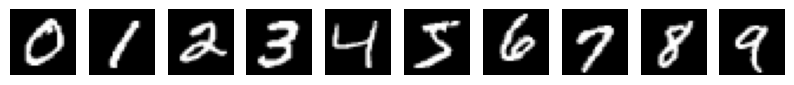

In [54]:
# Load the MNIST dataset using Keras
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Print the minimum and maximum values of the training data
print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("y_train Min:", np.min(y_train))
print("y_train Max:", np.max(y_train))

print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Print the number of samples for each class
for i in range(10):
    print("Training (", i, ") - ", np.sum(y_train == i), "; Test (", i, ") - ", np.sum(y_test == i))

# Display the first training image for each class
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[y_train == i][0], cmap='gray')
    plt.axis('off')

## Data Pre-processing


In [55]:
# Normalize the input data
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train Min:", np.min(x_train))
print("x_train Max:", np.max(x_train))
print("x_train dtype:", x_train.dtype)

x_train Min: 0.0
x_train Max: 1.0
x_train dtype: float64


In [56]:
# Convert the labels to the appropriate datatype for TensorFlow
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

## Data Analysis

Top 10 correlated pairs:
(9, 4) : 0.8978909301898066
(8, 5) : 0.8688165934976693
(9, 7) : 0.854137202212662
(5, 3) : 0.8488986033636331
(8, 3) : 0.8179677931758483
(9, 8) : 0.7985014177503245
(8, 2) : 0.7902616532929929
(6, 2) : 0.7696276051784255
(5, 0) : 0.7597062495955831
(9, 5) : 0.752567893745871


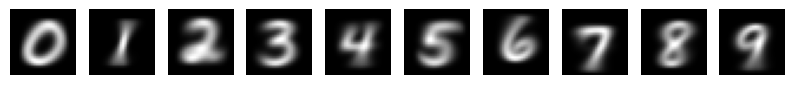

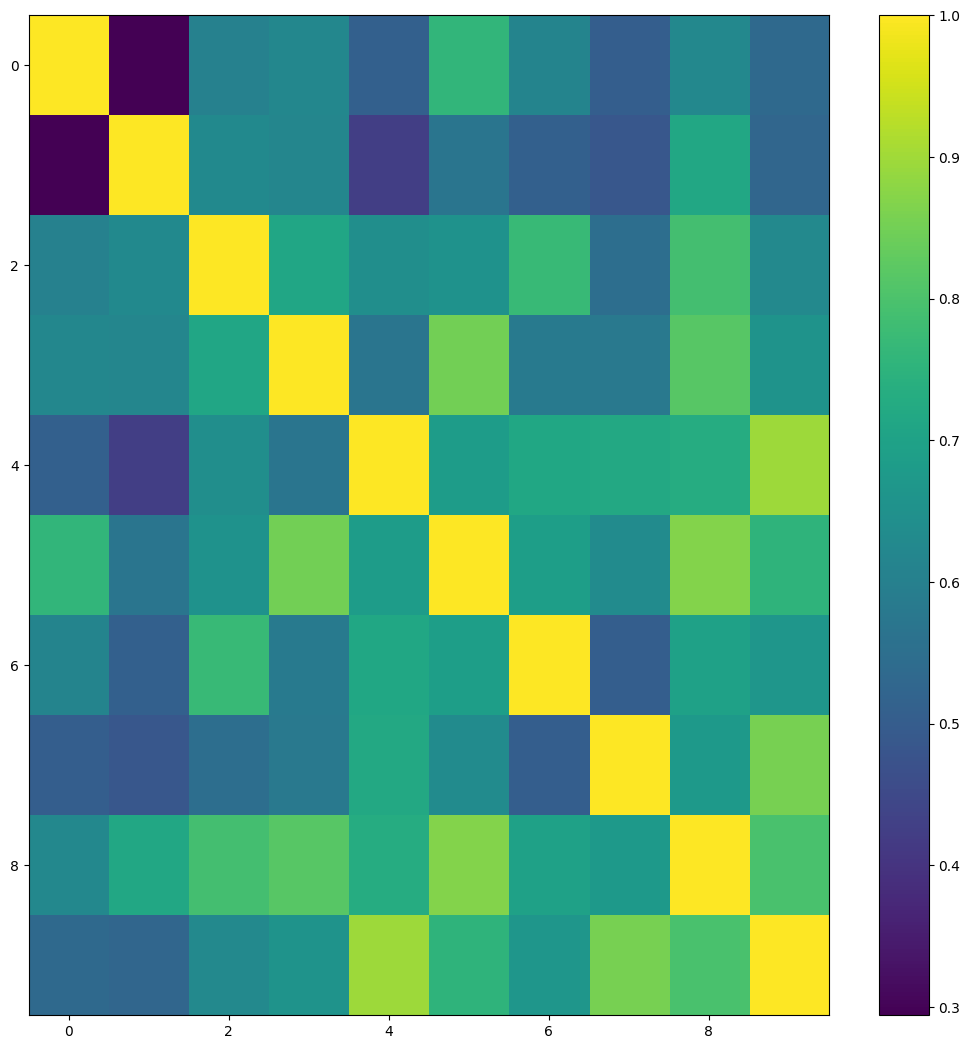

In [57]:
# Average the pixel values for each class
class_means = np.zeros((10, 28, 28))
for i in range(10):
    class_means[i] = np.mean(x_train[y_train == i], axis=0)

# Display the average images
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(class_means[i], cmap='gray')
    plt.axis('off')

# Look at the correlation between the average images of each class
corr = np.corrcoef(class_means.reshape(10, -1))

# Print the top 5 correlated pairs (excluding the diagonal and lower triangle)
print("Top 10 correlated pairs:")
tmp = corr.copy()
np.fill_diagonal(tmp, 0)
tmp = np.tril(tmp, k=0)

for i in range(10):
    idx = np.unravel_index(np.argmax(tmp), tmp.shape)
    print(idx, ":", tmp[idx])
    tmp[idx] = 0

# Display the correlation matrix as an image
plt.figure(figsize=(10, 10))
plt.imshow(corr)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)


From the above correlation coefficients, it looks like the following 

## Partition the Dataset into Train & Validation Subsets

In [58]:
# Randomly select 5000 samples from the training data for the training set
np.random.seed(42)
val_size = 5000
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, stratify=y_train)

# Show the shape of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (55000, 28, 28)
y_train shape: (55000,)
x_val shape: (5000, 28, 28)
y_val shape: (5000,)


## Helper Functions
The following helper functions are inteded to be used througout all experiments.

In [59]:
def plot_learning_curves(history, title):
    numOfEpochs = history.epoch[-1]+1
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation', color="r")
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training', color="b")
    plt.legend(loc=0, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

In [67]:
# Create an early stopping callback for use across all experiments
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

## Experiment 1
Create a deep feed forward network with the following characteristics:
- 2 hidden layers 
    - Hidden layer 1: neurons=300 
    - Hidden layer 2: neurons=100
- SGD Learning Rate: 0.1
- kernel_initializer (all layers): zeros
- activation (hidden layers): sigmoid
- Dropout (hidden layers): None
- Max 50 epochs with early exit

In [68]:
# Create a MLP feedforward neural network using Keras
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

model_ex1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='sigmoid', kernel_initializer='zeros', name='hidden1'),
    tf.keras.layers.Dense(100, activation='sigmoid', kernel_initializer='zeros', name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='zeros', name='output')
])

optimizer_ex1 = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn_ex1 = tf.keras.losses.SparseCategoricalCrossentropy()
model_ex1.compile(optimizer=optimizer_ex1, loss=loss_fn_ex1, metrics=['accuracy'])

model_ex1.summary()

/Users/zswanson/engineering/unl_masters/fall_2024/ecen878_practical_ml/ecen878_mlp_classifiers/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train the model using the training and validation sets with early stopping
history_ex1 = model_ex1.fit(
    x_train, 
    y_train, 
    epochs=50, 
    validation_data=(x_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1047 - loss: 2.3140 - val_accuracy: 0.1044 - val_loss: 2.3028
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1397 - loss: 2.2711 - val_accuracy: 0.2650 - val_loss: 2.0001
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2873 - loss: 1.9388 - val_accuracy: 0.3122 - val_loss: 1.8055
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3257 - loss: 1.7719 - val_accuracy: 0.3412 - val_loss: 1.7121
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3474 - loss: 1.6913 - val_accuracy: 0.3556 - val_loss: 1.6692
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3587 - loss: 1.6518 - val_accuracy: 0.3620 - val_loss: 1.6441
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3675 - loss: 1.6275 - val_accuracy: 0.3652 - val_loss: 1.6260
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3715 - loss: 1.6097 - 

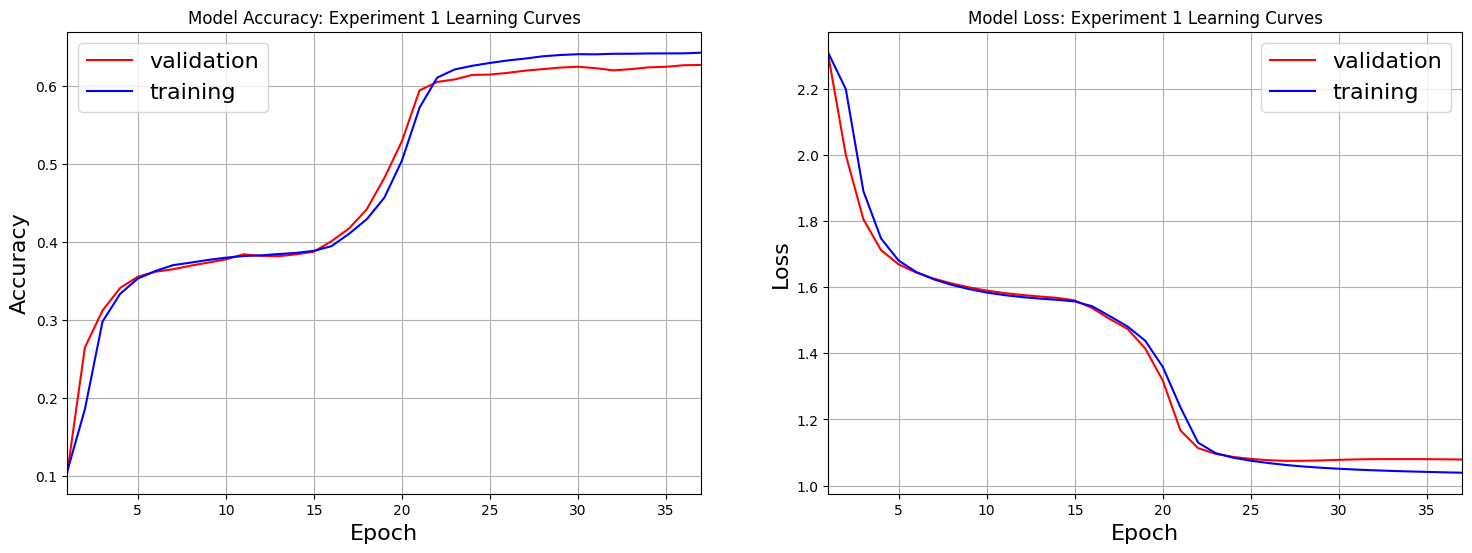

In [70]:
plot_learning_curves(history_ex1, "Experiment 1 Learning Curves")

In [71]:
# Compute the accuracy of the model on the training and test sets
train_loss, train_accuracy = model_ex1.evaluate(x_train, y_train, verbose=0)
test_loss, test_accuracy = model_ex1.evaluate(x_test, y_test, verbose=0)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.6258545517921448
Test Accuracy: 0.6219000220298767


In [72]:
# Generate predictions for the test set
y_pred = model_ex1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[878   0   6   7   0  66  21   0   2   0]
 [  1 985   2   4  44   2   3   2   4  88]
 [ 74   5 227  49 147 111 297   9  96  17]
 [ 54   3  16 586   7 215   1  75  40  13]
 [  0  26   8   0 882   0  50   0   1  15]
 [161   0  98 159  19 371  37  11  35   1]
 [ 14   0  25   0  32   5 880   0   1   1]
 [  1  24   2  82  14   9   0 828  20  48]
 [ 61   5 192  88 160 151  52  22 196  47]
 [  5 103   6  22 363  14   4  70  36 386]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       980
           1       0.86      0.87      0.86      1135
           2       0.39      0.22      0.28      1032
           3       0.59      0.58      0.58      1010
           4       0.53      0.90      0.67       982
           5       0.39      0.42      0.40       892
           6       0.65      0.92      0.76       958
           7       0.81      0.81      0.81      1028
